In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pickle
%matplotlib inline


def display_image(image):
    
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.title(f"Shape : {image.shape}")
    plt.axis("off")
    plt.show()

def convert_image(image):
    return cv2.cvtColor(image ,cv2.COLOR_BGR2RGB)

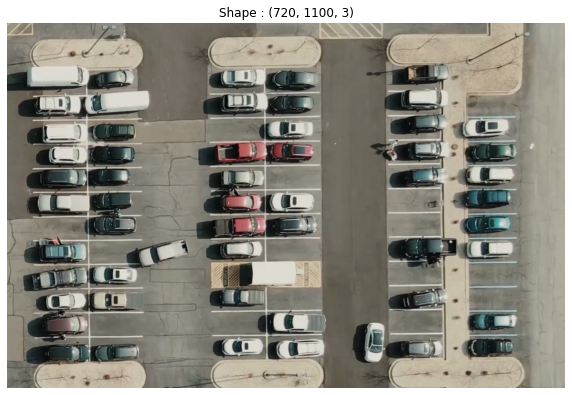

In [2]:
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject/carParkImg.png"
img = cv2.imread(path)
image = convert_image(img)
display_image(image)

In [3]:
path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject/carParkImg.png"
main = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject"
width,height = 107,48

# Neden bunu yaptık sorusu normalde biz her işaretlediğimizde kaydediyor
# Fakat biz tekrardan açıp tekrardan işaretlemek istemiyoruz 
# Eğer var ise kaydedilenlerle ilerlemek istiyoruz !!!!
# Onun için bunları sorgulama yaparak devam ediyoruz !!!
try:
    with open(f"{main}/CarParkPositions","rb") as f:
        posList = pickle.load(f)
        
except:
    posList = []
        

def mouseClick(events,x,y,flags,params):
    
    if events == cv2.EVENT_LBUTTONDOWN:
        posList.append((x,y))
    if events == cv2.EVENT_RBUTTONDOWN:
        for i,pos in enumerate(posList):
            x1,y1 = pos
            if x1 < x < x1+width and y1 < y < y1+height:
                  posList.pop(i)
    
    with open(f"{main}/CarParkPositions","wb") as f:
        pickle.dump(posList,f)
        
while True:
    img = cv2.imread(path)
    for pos in posList:
        cv2.rectangle(img,pos,(pos[0]+width,pos[1]+height),(255,0,255),2)
    
    cv2.imshow("Image",img)
    cv2.setMouseCallback("Image",mouseClick)
    if cv2.waitKey(1) & 0xff == ord("q"):
        break
        
cv2.destroyAllWindows()

In [21]:
import cv2
import numpy as np
import pickle

main = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject"
video_path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject/carPark.mp4"
width,height = 107,48
cap = cv2.VideoCapture(video_path)

video_writer = cv2.VideoWriter("/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject/space.mp4",
                              cv2.VideoWriter_fourcc('M','J','P','G'),30,(640,480))

class FileManager():        
    def __init__(self, filename, mode):
        self.filename = filename
        self.mode = mode
                  
    def __enter__(self):
        self.file = open(self.filename, self.mode)
        return self.file
       
    def __exit__(self, exc_type, exc_value, traceback):
        self.file.close()
        
with FileManager(f"{main}/CarParkPositions", 'rb') as file:
    posList = pickle.load(file)   
print(posList)


# Resmin konumunu al sonra zaten metin için width,height oluşturuluyor !!
def putTextRect(image,text, pos, scale = 3, thickness = 3, colorT = (255,255,255),
                colorR = (255,0,255),font = cv2.FONT_HERSHEY_PLAIN,
                offset = 15, border = None, colorB = (0,255,0)):
    
    ox,oy = pos
    (w,h),_ = cv2.getTextSize(text,font,scale,thickness)
    x1,y1,x2,y2 = ox-offset , oy + offset, ox + w + offset,oy-h-offset
    cv2.rectangle(image, (x1, y1), (x2, y2), colorR, cv2.FILLED)
    
    if border is not None:    
        cv2.rectangle(image, (x1, y1), (x2, y2), colorB, cv2.FILLED)
        
    cv2.putText(image, text, (ox, oy), font, scale, colorT, thickness)
    
    return image,[x1,y2,x2,y1]

def checkParkingSpace(imageOriginal,imageDilate):
    
    spaceCounter = 0
    parkSpace = len(posList)
    
    for pos in posList:
        x,y = pos            
        imgCrop = imageDilate[y:y+height,x:x+width]
        #display_image(convert_image(imgCrop))
        count = cv2.countNonZero(imgCrop)
        #putTextRect(imageOriginal,str(count),(x,y+height-5),scale = 1,thickness=1,offset = 0)
        
        if count < 800:
            color = (0,255,0)
            putTextRect(imageOriginal,"Available",(x,y+height-5),scale = 1,thickness=2,offset = 0,colorR=color)
            tickness = 5
            spaceCounter+=1
        else:
            color = (0,0,255)
            putTextRect(imageOriginal,"Full",(x,y+height-5),scale = 1,thickness=2,offset = 0,colorR=color)
            tickness = 2
              
        cv2.rectangle(imageOriginal,pos,(pos[0]+width,pos[1]+height),color,tickness)
        
    putTextRect(imageOriginal,f"Available : {spaceCounter}/{parkSpace}",(100,50),
                scale = 1,thickness=2,offset = 20,colorR=(0,255,0))

while True:
    
    conn, frame = cap.read()
    if conn:
        
        frameGray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
        frameBlur = cv2.GaussianBlur(frameGray,(3,3),1)
        frameThreshold = cv2.adaptiveThreshold(frameBlur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                        cv2.THRESH_BINARY_INV,25,16)
        frameMedian = cv2.medianBlur(frameThreshold,5)
        kernel = np.ones((3,3),np.uint8)
        frameDilate = cv2.dilate(frameMedian,kernel,iterations = 1)

        checkParkingSpace(frame,frameDilate)  
    
    else:
        break
        
    video_writer.write(frame)
    cv2.imshow("Frame",frame)
    #cv2.imshow("Threshold",frameThreshold)
    #cv2.imshow("Median",frameMedian)
    #cv2.imshow("Dilate",frameDilate)
    
    if cv2.waitKey(1) & 0xff == ord("q"):
        break
        
        
video_writer.release()        
cap.release()
cv2.destroyAllWindows()

[(403, 187), (401, 284), (751, 469), (753, 564), (912, 520), (905, 140), (512, 426), (511, 524), (49, 97), (159, 101), (160, 147), (159, 192), (51, 194), (52, 147), (52, 244), (52, 290), (53, 337), (54, 388), (54, 435), (56, 480), (57, 528), (58, 575), (58, 622), (168, 574), (167, 621), (167, 526), (162, 477), (164, 428), (164, 384), (160, 337), (162, 288), (161, 242), (747, 84), (749, 134), (751, 184), (751, 233), (753, 282), (752, 326), (752, 377), (752, 427), (912, 476), (912, 426), (910, 378), (908, 333), (910, 284), (908, 238), (907, 190), (913, 571), (912, 619), (753, 612), (754, 521), (405, 570), (406, 619), (512, 571), (515, 620), (402, 379), (401, 333), (511, 285), (512, 332), (511, 377), (400, 236), (511, 233), (510, 188), (401, 141), (510, 142), (397, 91), (511, 92), (404, 522), (403, 427)]


403 187 468 177


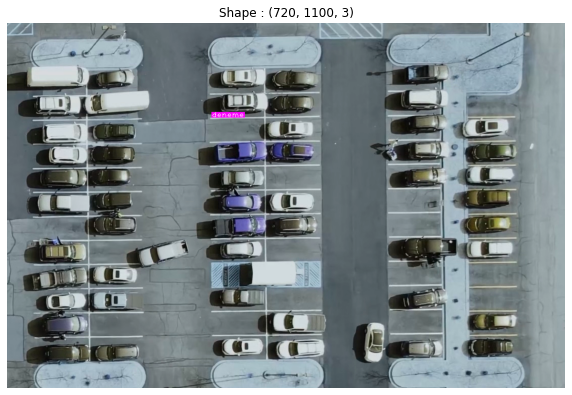

In [13]:
x,y = (403, 187)
width,height = 107,48

path = "/Users/gokhanersoz/Desktop/Hepsi/OpenCV/PROJECTS/Resources/CarParkProject/carParkImg.png"
img = cv2.imread(path)
l = 50
imgCrop = img[y-l:y+height+l,x-l:x+width+l]
ox,oy = x,y

scale = 1
thickness = 1

colorB = (0,255,0)
colorT = (255,255,255)
colorR = (255,0,255)

font = cv2.FONT_HERSHEY_PLAIN
offset = 0
text = "deneme"
border = None

# Bunlar yazının w,h dikkat !!!
(w,h),_ = cv2.getTextSize(text,fontFace = cv2.FONT_HERSHEY_PLAIN,fontScale = 1,thickness = 1)
x1,y1,x2,y2 = ox-offset , oy + offset, ox + w + offset,oy-h-offset
print(x1,y1,x2,y2)

cv2.rectangle(img, (x1, y1), (x2, y2), colorR, cv2.FILLED)

if border is not None:    
    cv2.rectangle(img, (x1, y1), (x2, y2), colorB, cv2.FILLED)
        
display_image(cv2.putText(img, text, (ox, oy), font, scale, colorT, thickness))